# Compare datasets graphically

Export AM build information and tensile test results from different tables in the *MI Training* database, process the data using a `pandas` DataFrame, and plot summaries of the data using `matplotlib` and `seaborn`.

## Get data from Granta MI

Connect to MI and specify a database.

In [1]:
from GRANTA_MIScriptingToolkit import granta as mi

session = mi.Session('localhost', autologon=True)
training_db = session.get_db('MI Training')
training_db.set_unit_system('Metric')

Specify the records and attributes you want to export from the first table. 

For this example, we need *Build ID* and *Travel Speed* for all records in the *AM Builds* table.

In [2]:
am_builds = training_db.get_table('AM Builds')
build_records = am_builds.all_records()
build_attributes = ['Build ID', 'Travel Speed']
am_builds.bulk_fetch(build_records, attributes=build_attributes)

Specify the records you want to export from the second table. Here, a link group is used to export only records linked to records in the first table. 

Alternatively, you can specify a table with no link groups to the original table, as long as you can join the two datasets later on. For example, we could search for all records created after a certain date, or tested on a certain machine.

In [3]:
link_group = 'Tensile tests from this build'

# Use a set comprehension to ensure we only select each record once
tensile_test_records = {tr for br in build_records for tr in br.links[link_group]}
tensile_test_records = list(tensile_test_records)

Specify the attributes you want to export from the second table. *Build ID* will be used to relate the tensile tests to the appropriate build data.

In [4]:
tensile_test_data = training_db.get_table('Tensile Test Data')
tensile_attributes = ['Build ID', 'Specimen ID', '0.2% Offset Yield Stress', 'Ultimate Tensile Strength', 'Specimen Orientation']
tensile_test_data.bulk_fetch(tensile_test_records, attributes=tensile_attributes)

## Use DataFrames to pre-process and append data

### Build a separate DataFrame for each table

Create a DataFrame for each Granta MI table. The DataFrames are built from two separate lists of dictionaries:

In [5]:
def get_attr_vals(attributes, r):
    return {mi_attr: r.attributes[mi_attr].value for mi_attr in attributes}

build_data = [get_attr_vals(build_attributes, r) for r in build_records]
tensile_data = [get_attr_vals(tensile_attributes, r) for r in tensile_test_records]

Create a DataFrame `build_df` that contains the build records. Set the DataFrame index to be the *Build ID* attribute
value.

In [6]:
import pandas as pd

build_df = pd.DataFrame(build_data).set_index('Build ID')
build_df.head()

,Travel Speed
Build ID,
2013-04-15 CLAD-2321 01,0.0086
2013-04-16 CLAD-2321 02,0.0096
2013-04-17 CLAD-2321 03,0.0106
2013-04-17 CLAD-2321 04,0.0116
2013-04-17 CLAD-2321 05,0.0126


Create a second DataFrame, `tensile_df`, that contains the tensile test results. Again, set the index to be the
*Build ID* attribute value.

In [7]:
tensile_df = pd.DataFrame(tensile_data).set_index('Build ID')
tensile_df.head()

,Specimen ID,0.2% Offset Yield Stress,Ultimate Tensile Strength,Specimen Orientation
Build ID,,,,
2013-04-17 CLAD-2321 03,L15L14AD 3T,115.11,149.900,L
2013-04-17 CLAD-2321 04,L16L14AA34T,127.70,136.420,LT
2013-04-15 CLAD-2321 01,L13L12AA7T,132.43,131.400,L
2013-04-17 CLAD-2321 04,L16L14AA22T,127.50,135.660,LT
2013-04-17 CLAD-2321 04,L16L14AA1T,133.10,141.835,L


### Join the dataframes

Use the `dataframe.join()` method to create a DataFrame with both sets of data. The join type will default to left-join if not specified; this is fine in our example because the records were linked via a smart link in Granta MI, and so the set of indices is the same for both DataFrames.

In [8]:
df = build_df.join(tensile_df)
df.head()

,Travel Speed,Specimen ID,0.2% Offset Yield Stress,Ultimate Tensile Strength,Specimen Orientation
Build ID,,,,,
2013-04-15 CLAD-2321 01,0.0086,L13L12AA7T,132.430,131.40,L
2013-04-15 CLAD-2321 01,0.0086,L13L12AA11T,127.300,126.81,AT
2013-04-15 CLAD-2321 01,0.0086,L13L12AA13T,121.125,121.77,LT
2013-04-15 CLAD-2321 01,0.0086,L13L12AA17T,121.885,122.76,LT
2013-04-15 CLAD-2321 01,0.0086,L13L12AA9T,133.000,123.75,L


### Units

Finally, create a `units` dict so you can create plots with meaningful axis labels.

In [9]:
attr_defs = [am_builds.attributes[attr] for attr in build_attributes] + \
            [tensile_test_data.attributes[attr] for attr in tensile_attributes]
units = {attr.name: attr.unit for attr in attr_defs if attr.unit}
units

{'Travel Speed': 'm/s',
 '0.2% Offset Yield Stress': 'MPa',
 'Ultimate Tensile Strength': 'MPa'}

## Plot the data

This code snippet is optional, and is included to increase the size of all plots generated in this
notebook.

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125

### Investigate the relationship between two properties

Create a scatter plot comparing *Ultimate Tensile Strength* of samples to the *Travel Speed* used during the build.

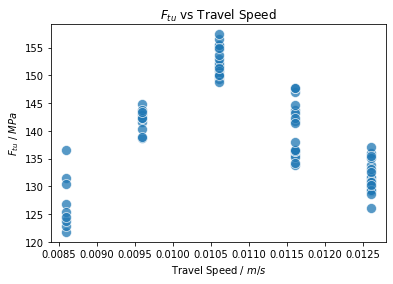

In [11]:
import seaborn as sns

travel_speed_unit = units['Travel Speed']
ftu_unit = units["Ultimate Tensile Strength"]
travel_speed_label = rf'Travel Speed / ${travel_speed_unit}$'
ftu_label = rf'$F_{{tu}}$ / ${ftu_unit}$'

ax = sns.scatterplot(data=df, x="Travel Speed", y="Ultimate Tensile Strength", alpha=0.75, s=100)
ax.set_xlabel(travel_speed_label)
ax.set_ylabel(ftu_label)
_ = ax.set_title('$F_{{tu}}$ vs Travel Speed')

There is a clear dependence of the *Ultimate Tensile Strength* on the *Travel Speed*. It is also clear that *Travel Speed*
is an independent variable, with the values chosen for each build falling into a set of well-defined bins. 

Instead of judging the distribution by eye, we can use box plots to describe the distribution of values.

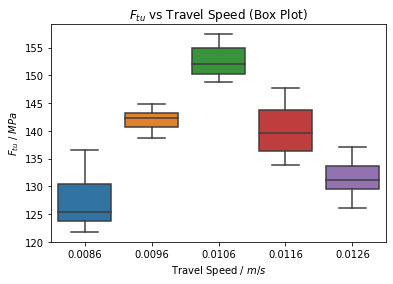

In [12]:
ax = sns.boxplot(data=df, x="Travel Speed", y="Ultimate Tensile Strength")
ax.set_xlabel(travel_speed_label)
ax.set_ylabel(ftu_label)
_ = ax.set_title('$F_{{tu}}$ vs Travel Speed (Box Plot)')

For a more detailed view of the distribution, we can replace the box plots with violin plots.

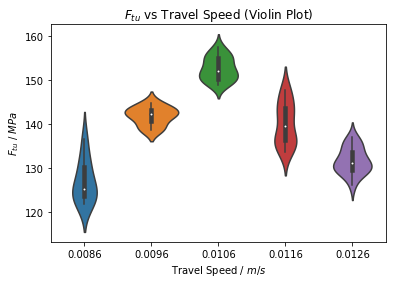

In [13]:
ax = sns.violinplot(data=df, x="Travel Speed", y="Ultimate Tensile Strength")
ax.set_xlabel(travel_speed_label)
ax.set_ylabel(ftu_label)
_ = ax.set_title('$F_{{tu}}$ vs Travel Speed (Violin Plot)')

### Investigate the impact of a third property

The orientation of each specimen during the test was also exported, but not included on the plots above. 

The simplest way to visualize this data is to add it to the original scatter plot as a color axis.

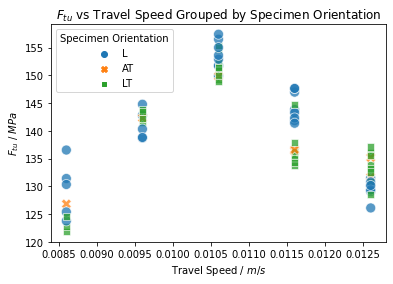

In [14]:
ax = sns.scatterplot(data=df,
                     x="Travel Speed",
                     y="Ultimate Tensile Strength",
                     alpha=0.75,
                     s=100,
                     hue='Specimen Orientation',
                     style='Specimen Orientation')
ax.set_xlabel(travel_speed_label)
ax.set_ylabel(ftu_label)
_ = ax.set_title('$F_{{tu}}$ vs Travel Speed Grouped by Specimen Orientation')

This scatter plot contains different markers for each orientation, but is difficult to interpret. Some difference in
distribution is visible for each orientation, but it's difficult to discern any detail.

A clearer representation would be to add the orientation to the violin plot above. This can be done with a 'split' violin plot, but only for two values of *Specimen Orientation*. We can remove the 'AT' results from the dataset, but first we want to check how many data points would be removed using the `DataFrame.value_counts()` method.

In [15]:
df['Specimen Orientation'].value_counts()

L     34
LT    32
AT     7
Name: Specimen Orientation, dtype: int64

There are only 7 values for 'AT', which is less than 10% of the overall dataset. 

The code below creates a series of `True` or `False` values in `rows_to_keep` (set to `True` if the value is in the specified list). `rows_to_keep` is then passed as a selector into the DataFrame, which maps the list onto the DataFrame rows and returns a new DataFrame with only the `True` rows included.

In [16]:
rows_to_keep = df['Specimen Orientation'].map(lambda x: x in ['L', 'LT'])
df_L_or_LT = df[rows_to_keep]
df_L_or_LT.head()

,Travel Speed,Specimen ID,0.2% Offset Yield Stress,Ultimate Tensile Strength,Specimen Orientation
Build ID,,,,,
2013-04-15 CLAD-2321 01,0.0086,L13L12AA7T,132.430,131.40,L
2013-04-15 CLAD-2321 01,0.0086,L13L12AA13T,121.125,121.77,LT
2013-04-15 CLAD-2321 01,0.0086,L13L12AA17T,121.885,122.76,LT
2013-04-15 CLAD-2321 01,0.0086,L13L12AA9T,133.000,123.75,L
2013-04-15 CLAD-2321 01,0.0086,L13L12AA3T,126.065,125.37,L


Re-run `.value_counts()` from before to confirm the change was successful.

In [17]:
df_L_or_LT['Specimen Orientation'].value_counts()

L     34
LT    32
Name: Specimen Orientation, dtype: int64

Specify `split=True` in the `sns.violinplot` constructor to show the two distributions side-by-side. The dependence
on *Specimen Orientation* is now much clearer.

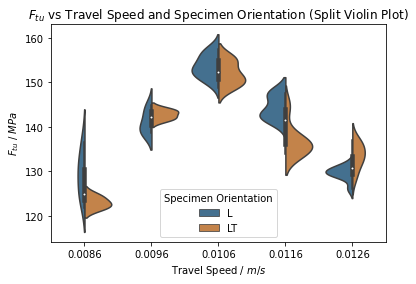

In [18]:
ax = sns.violinplot(data=df_L_or_LT,
                    x="Travel Speed",
                    y="Ultimate Tensile Strength",
                    hue="Specimen Orientation",
                    split=True,
                    saturation=0.5)
ax.set_xlabel(travel_speed_label)
ax.set_ylabel(ftu_label)
ax.legend(title='Specimen Orientation', loc='lower center')
_ = ax.set_title('$F_{{tu}}$ vs Travel Speed and Specimen Orientation (Split Violin Plot)')